#**Machine Learning Models**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import make_scorer, fbeta_score, classification_report, roc_curve, auc, recall_score, confusion_matrix

from xgboost import XGBClassifier

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, KMeansSMOTE
from imblearn.ensemble import BalancedRandomForestClassifier, RUSBoostClassifier, EasyEnsembleClassifier
from imblearn.under_sampling import (RandomUnderSampler, NearMiss,
                                     EditedNearestNeighbours, RepeatedEditedNearestNeighbours,
                                     NeighbourhoodCleaningRule)

In [ ]:
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/taiwan/finalData.csv'
df = pd.read_csv(file_path)
df.head()

Mounted at /content/drive


,After-tax Net Profit Growth Rate,Cash Turnover Rate,Cash flow rate,Cash/Total Assets,Current Assets/Total Assets,Current Ratio,Debt ratio %,Fixed Assets Turnover Frequency,Interest-bearing debt interest rate,Inventory Turnover Rate (times),...,ROA(C) before interest and depreciation before interest,Research and development expense rate,Retained Earnings to Total Assets,Revenue Per Share (Yuan ¥),Tax rate (A),Total Asset Growth Rate,Total debt/Total net worth,Total expense/Assets,Working Capital to Total Assets,Bankruptcy
0,0.688979,4.580000e+08,0.458143,0.004094,0.190643,0.002259,0.207576,1.165007e-04,0.000725,1.820926e-04,...,0.370594,0.0,0.903225,0.017560,0.0,4.980000e+09,0.021266,0.064856,0.672775,1
1,0.689693,2.490000e+09,0.461867,0.014948,0.182419,0.006016,0.171176,7.190000e+08,0.000647,9.360000e+09,...,0.464291,0.0,0.931065,0.021144,0.0,6.110000e+09,0.012502,0.025516,0.751111,1
2,0.689463,7.610000e+08,0.458521,0.000991,0.602806,0.011543,0.207516,2.650000e+09,0.000790,6.500000e+07,...,0.426071,25500000.0,0.909903,0.005944,0.0,7.280000e+09,0.021248,0.021387,0.829502,1
3,0.689110,2.030000e+09,0.465705,0.018851,0.225815,0.004194,0.151465,9.150000e+09,0.000449,7.130000e+09,...,0.399844,0.0,0.906902,0.014368,0.0,4.880000e+09,0.009572,0.024161,0.725754,1
4,0.689697,8.240000e+08,0.462746,0.014161,0.358380,0.006022,0.106509,2.935211e-04,0.000686,1.633674e-04,...,0.465022,0.0,0.913850,0.029690,0.0,5.510000e+09,0.005150,0.026385,0.751822,1


In [ ]:
X = df.drop(columns=['Bankruptcy'])
y = df['Bankruptcy']

xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f'\nTraining set shape: {xTrain.shape}')
target_counts = yTrain.value_counts()
print(f'Training set has the following distribution of classes: {target_counts}')
print(f'\nTest set shape: {xTest.shape}')
target_counts = yTest.value_counts()
print(f'Test set has the following distribution of classes: {target_counts}')


Training set shape: (5455, 28)
Training set has the following distribution of classes: Bankruptcy
0    5279
1     176
Name: count, dtype: int64

Test set shape: (1364, 28)
Test set has the following distribution of classes: Bankruptcy
0    1320
1      44
Name: count, dtype: int64


In [ ]:
print('missing values: ', df.isnull().sum().sum())
print('duplicates values: ', df.duplicated().sum())

missing values:  0
duplicates values:  0


#**Training different algorithms (without hypertuning) for different methods of sampling**

In [ ]:
# SAMPLERS (non, under and over sampling)

samplers = {
    'No_Sampling': None,

    #undersampling
    'Random_Undersampling': RandomUnderSampler(random_state=42),
    'NearMiss': NearMiss(version=1),
    'ENN': EditedNearestNeighbours(),
    'RENN': RepeatedEditedNearestNeighbours(),
    'NCR': NeighbourhoodCleaningRule(),

    #oversampling
    'SMOTE': SMOTE(random_state=42),
    'BorderlineSMOTE': BorderlineSMOTE(kind='borderline-1', random_state=42),
    'KMeansSMOTE': KMeansSMOTE(cluster_balance_threshold=0.01, random_state=42),
}


#CLASSIFIERS
#quick experiment without hyperparameter tuning

classifiers = {
    'LogReg': LogisticRegression(max_iter=2000, random_state=42),
    'NeuralNet': MLPClassifier(max_iter=500, early_stopping=True, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'NaiveBayes': GaussianNB(),
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                             random_state=42, n_jobs=-1),
    'BalancedRandomForest': BalancedRandomForestClassifier(random_state=42),
    'RUSBoost':RUSBoostClassifier(random_state=42),
    'EasyEnsemble':EasyEnsembleClassifier(random_state=42)
}


results=[]


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f2_scorer = make_scorer(fbeta_score, beta=2)

scoring_metrics = {
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'f2': f2_scorer,
    'auc': 'roc_auc'
}

header = f"{'Sampler':<22} | {'Classifier':<22} | {'AUC':<6} | {'Recall':<6} | {'Prec.':<6} | {'F1':<6} | {'F2':<6} | {'Time':<5}"
print(header)
print("-" * len(header))

for sampler_name, sampler in samplers.items():
    for clf_name, clf in classifiers.items():

        if clf_name in ['BalancedRandomForest', 'RUSBoost', 'EasyEnsemble'] and sampler_name != 'No_Sampling':
            continue

        start_time = time.time()

        steps = [('scaler', StandardScaler())]

        if sampler is not None:
            steps.append(('sampler', sampler))

        steps.append(('classifier', clf))

        model_pipeline = ImbPipeline(steps)

        #Cross Validation
        try:
            cv_results = cross_validate(model_pipeline, X, y, cv=cv, scoring=scoring_metrics, n_jobs=-1)

            #means of every score
            mean_auc = np.mean(cv_results['test_auc'])
            mean_rec = np.mean(cv_results['test_recall'])
            mean_prec = np.mean(cv_results['test_precision'])
            mean_f1 = np.mean(cv_results['test_f1'])
            mean_f2 = np.mean(cv_results['test_f2'])
            elapsed_time = time.time() - start_time

            print(f"{sampler_name:<22} | {clf_name:<22} | {mean_auc:.4f} | {mean_rec:.4f} | {mean_prec:.4f} | {mean_f1:.4f} | {mean_f2:.4f} | {elapsed_time:.2f}")

            results.append({
                'Sampler': sampler_name,
                'Classifier': clf_name,
                'AUC': mean_auc,
                'Recall': mean_rec,
                'Precision': mean_prec,
                'F1': mean_f1,
                'F2': mean_f2,
                'Time': elapsed_time
            })

        except Exception as e:
            #if some models fail (kMeansSMOTE may not find clusters)
            print(f"Error in {sampler_name} + {clf_name}: {str(e)}")

df_results = pd.DataFrame(results)

Sampler                | Classifier             | AUC    | Recall | Prec.  | F1     | F2     | Time 
----------------------------------------------------------------------------------------------------
No_Sampling            | LogReg                 | 0.9172 | 0.1909 | 0.5906 | 0.2871 | 0.2204 | 3.92
No_Sampling            | NeuralNet              | 0.8188 | 0.0682 | 0.6323 | 0.1166 | 0.0817 | 1.88
No_Sampling            | SVM                    | 0.8477 | 0.0364 | 0.5500 | 0.0679 | 0.0447 | 7.26
No_Sampling            | NaiveBayes             | 0.8859 | 0.9727 | 0.0380 | 0.0732 | 0.1644 | 0.24
No_Sampling            | RandomForest           | 0.9233 | 0.1364 | 0.6153 | 0.2220 | 0.1612 | 13.46
No_Sampling            | XGBoost                | 0.9157 | 0.2273 | 0.4995 | 0.3102 | 0.2543 | 2.30
No_Sampling            | BalancedRandomForest   | 0.9350 | 0.8182 | 0.2014 | 0.3225 | 0.5054 | 7.23
No_Sampling            | RUSBoost               | 0.8881 | 0.6864 | 0.1365 | 0.2161 | 0.3504 | 0.

#**Top-10 Models**

In [ ]:
print("\n=== TOP 10 MODELS BASED ON RECALL SCORE) ===")
display(df_results.sort_values(by='Recall', ascending=False).head(10))

#Save table
save_path = '/content/drive/MyDrive/taiwan/experiment_results.csv'
df_results.to_csv(save_path, index=False)


=== TOP 10 MODELS BASED ON RECALL SCORE) ===


,Sampler,Classifier,AUC,Recall,Precision,F1,F2,Time
3,No_Sampling,NaiveBayes,0.885928,0.972727,0.038033,0.073200,0.164416,0.241751
42,SMOTE,NaiveBayes,0.882435,0.968182,0.041063,0.078777,0.175475,0.268018
36,NCR,NaiveBayes,0.885077,0.931818,0.066404,0.123724,0.256929,1.743860
10,Random_Undersampling,NeuralNet,0.898741,0.927273,0.106234,0.190168,0.362148,0.515610
48,BorderlineSMOTE,NaiveBayes,0.861239,0.922727,0.047767,0.090719,0.197122,0.302512
24,ENN,NaiveBayes,0.881837,0.913636,0.084265,0.153706,0.304812,2.645361
30,RENN,NaiveBayes,0.878739,0.909091,0.091234,0.165401,0.323466,4.867401
54,KMeansSMOTE,NaiveBayes,0.852937,0.886364,0.071705,0.132581,0.270346,0.403288
11,Random_Undersampling,SVM,0.925859,0.868182,0.154995,0.262969,0.451913,0.505818
8,No_Sampling,EasyEnsemble,0.927181,0.868182,0.151711,0.258014,0.445583,11.768249


The combination of majority class undersampling using the `Random_Undersampling` method and the `MLPClassifier` algorithm was selected as the optimal model. This choice was driven by the high Recall—the most critical metric for this study—combined with superior Precision relative to other evaluated combinations.

#**Hypertuning Best Model**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


pipeline = ImbPipeline([
    ('sampler', RandomUnderSampler(random_state=42)),
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(max_iter=500, early_stopping=True, random_state=42))
])

#parameters for grid search
param_grid = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__solver': ['adam'],
    'mlp__alpha': [0.0001, 0.05],
    'mlp__learning_rate_init': [0.001, 0.01]
}

print("Running Grid Search")


grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"\nBest Parameters: {grid_search.best_params_}")

print(f"Best Recall Score (Class 1): {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_

Running Grid Search
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best Parameters: {'mlp__activation': 'relu', 'mlp__alpha': 0.05, 'mlp__hidden_layer_sizes': (50, 50), 'mlp__learning_rate_init': 0.01, 'mlp__solver': 'adam'}
Best Recall Score (Class 1): 0.8460



Classification Report for Threshold: 0.10
                precision    recall  f1-score   support

Non-Bankruptcy       1.00      0.71      0.83      1320
    Bankruptcy       0.10      0.95      0.18        44

      accuracy                           0.72      1364
     macro avg       0.55      0.83      0.51      1364
  weighted avg       0.97      0.72      0.81      1364


Classification Report for Threshold: 0.20
                precision    recall  f1-score   support

Non-Bankruptcy       1.00      0.77      0.87      1320
    Bankruptcy       0.12      0.95      0.22        44

      accuracy                           0.78      1364
     macro avg       0.56      0.86      0.54      1364
  weighted avg       0.97      0.78      0.85      1364


Classification Report for Threshold: 0.30
                precision    recall  f1-score   support

Non-Bankruptcy       1.00      0.82      0.90      1320
    Bankruptcy       0.14      0.91      0.24        44

      accuracy         

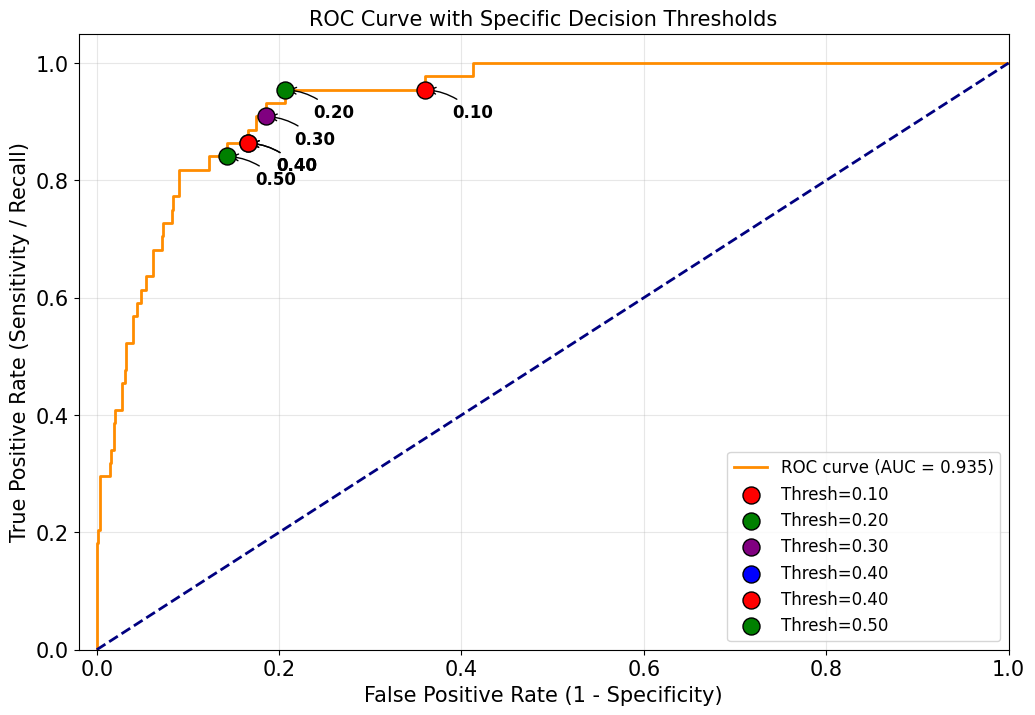

In [ ]:
custom_thresholds = np.array([0.10, 0.20, 0.30, 0.40, 0.40, 0.50])

y_pred_proba = best_model.predict_proba(X_test)[:, 1]


#Classification Reports
for thresh in custom_thresholds:
    y_pred_custom = (y_pred_proba >= thresh).astype(int)

    print(f"\n{'='*40}")
    print(f"Classification Report for Threshold: {thresh:.2f}")
    print(f"{'='*40}")
    print(classification_report(y_test, y_pred_custom, target_names=['Non-Bankruptcy', 'Bankruptcy']))

#roc auc
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 8))

#plot roc
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')


colors = ['red', 'green', 'purple', 'blue']

print("\nCordinates for each point (Threshold) on ROC")

for i, thresh in enumerate(custom_thresholds):

    idx = (np.abs(roc_thresholds - thresh)).argmin()

    point_fpr, point_tpr = fpr[idx], tpr[idx]

    #we put points of thresholds on the line
    plt.scatter(point_fpr, point_tpr, s=150, c=colors[i % len(colors)],
                edgecolor='black', zorder=5, label=f'Thresh={thresh:.2f}')

    #tag next to the point
    plt.annotate(f'{thresh:.2f}',
                 (point_fpr, point_tpr),
                 xytext=(20, -20),
                 textcoords='offset points',
                 arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"),
                 fontsize=12, fontweight='bold')

    print(f"Threshold {thresh:.2f} -> FPR: {point_fpr:.4f}, TPR: {point_tpr:.4f}")


plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=15)
plt.ylabel('True Positive Rate (Sensitivity / Recall)', fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.title('ROC Curve with Specific Decision Thresholds', fontsize=15)
plt.legend(loc="lower right", frameon=True, fontsize=12)
plt.grid(True, alpha=0.3)

plt.show()

The selection of the 0.20 threshold is considered optimal for the model's operational application. In a corporate bankruptcy risk management system, the 'cost' of failing to identify a company destined for insolvency (False Negative) is incomparably higher than the cost of a false alarm for a healthy enterprise (False Positive).

Adjusting the threshold ensures that the model functions as an effective 'safety net,' increasing the early warning capacity (Recall) to 95% of bankruptcy cases, while sacrificing a portion of overall Precision in order to minimize credit risk.


TRAIN SET Report (Threshold: 0.20)
                precision    recall  f1-score   support

Non-Bankruptcy       1.00      0.76      0.87      5279
    Bankruptcy       0.12      0.98      0.22       176

      accuracy                           0.77      5455
     macro avg       0.56      0.87      0.54      5455
  weighted avg       0.97      0.77      0.85      5455


TEST SET Report (Threshold: 0.20)
                precision    recall  f1-score   support

Non-Bankruptcy       1.00      0.77      0.87      1320
    Bankruptcy       0.12      0.95      0.22        44

      accuracy                           0.78      1364
     macro avg       0.56      0.86      0.54      1364
  weighted avg       0.97      0.78      0.85      1364



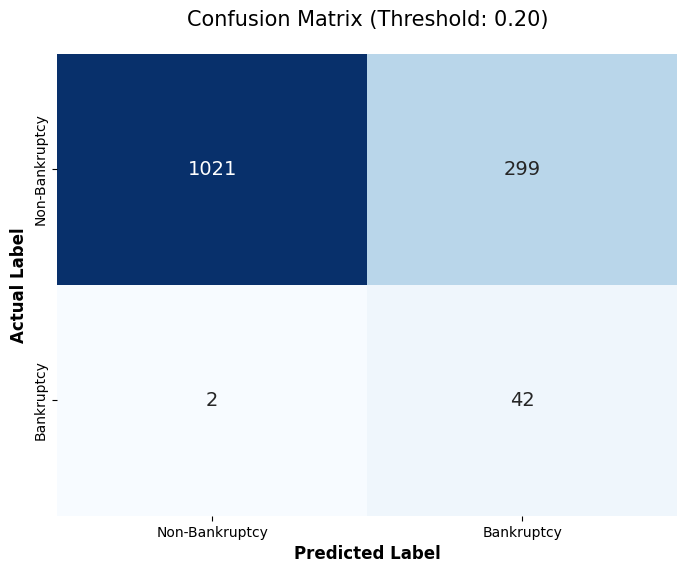

In [ ]:
selected_threshold = 0.20

#classification reports for train and test set to check for overfitting
y_train_proba = best_model.predict_proba(X_train)[:, 1]
y_train_pred_custom = (y_train_proba >= selected_threshold).astype(int)

print(f"\n{'='*60}")
print(f"TRAIN SET Report (Threshold: {selected_threshold:.2f})")
print(f"{'='*60}")
print(classification_report(y_train, y_train_pred_custom, target_names=['Non-Bankruptcy', 'Bankruptcy']))


y_test_pred_custom = (y_pred_proba >= selected_threshold).astype(int)

print(f"\n{'='*60}")
print(f"TEST SET Report (Threshold: {selected_threshold:.2f})")
print(f"{'='*60}")
print(classification_report(y_test, y_test_pred_custom, target_names=['Non-Bankruptcy', 'Bankruptcy']))


#Confusion Matrix for threshold 0.2
cm_t = confusion_matrix(y_test, y_test_pred_custom, labels=[0, 1])


plt.figure(figsize=(8, 6))
sns.heatmap(cm_t, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Bankruptcy', 'Bankruptcy'],
            yticklabels=['Non-Bankruptcy', 'Bankruptcy'],
            annot_kws={"size": 14})

plt.title('Confusion Matrix (Threshold: 0.20)', fontsize=15, pad=20)
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('Actual Label', fontsize=12, fontweight='bold')

plt.show()